# 1. Theoretical Foundation: Symplectic Geometry and Differential Forms

This notebook implements the core mathematical structures needed for exploring Lagrangian submanifolds.

## Setup and Imports

In [1]:
import numpy as np
import sympy as sp
from sympy.diffgeom import Manifold, Patch, CoordSystem
from sympy import Matrix, symbols, diff
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Symplectic Manifolds

Implementation plan:
1. Define base manifold class with coordinate charts
2. Implement symplectic form ω
3. Add methods for coordinate transformations
4. Verify symplectic properties (non-degeneracy, closure)

All tests passed!


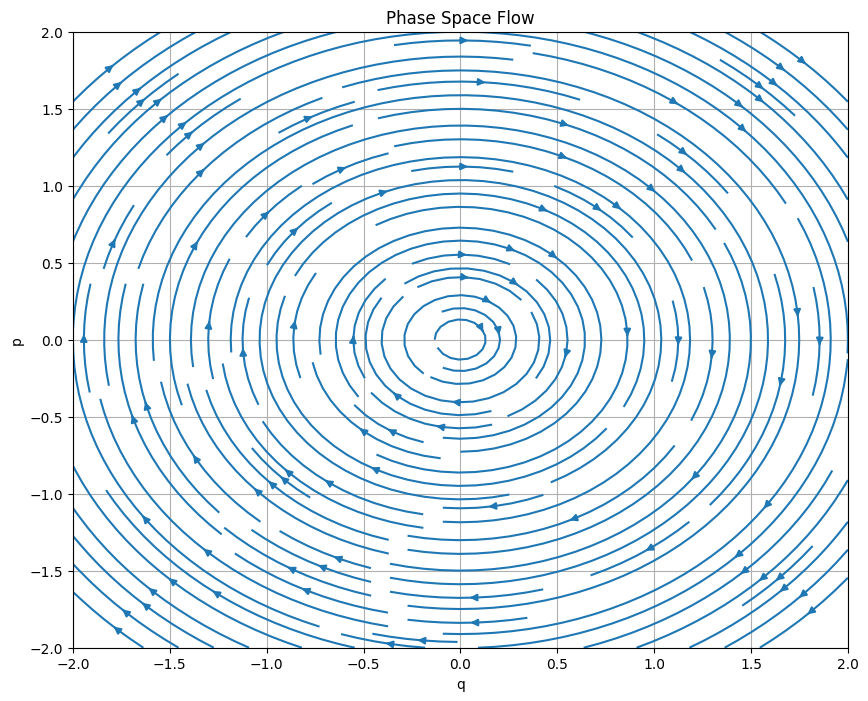

In [2]:
class SymplecticManifold:
    """A symplectic manifold (M,ω) with coordinate charts and symplectic form.
    
    A symplectic manifold is a smooth manifold M equipped with a closed, non-degenerate 2-form ω.
    This implementation focuses on the canonical symplectic form ω = ∑ dpi ∧ dqi.
    """
    def __init__(self, dimension: int):
        """Initialize 2n-dimensional symplectic manifold.
        
        Args:
            dimension: Phase space dimension (must be even)
        """
        if dimension % 2 != 0:
            raise ValueError("Symplectic manifold dimension must be even")
        
        self.dim = dimension
        self.n = dimension // 2  # Number of degrees of freedom
        
        # Create symbolic variables for coordinates
        self.q = sp.Matrix([sp.Symbol(f'q{i}') for i in range(self.n)])
        self.p = sp.Matrix([sp.Symbol(f'p{i}') for i in range(self.n)])
        self.coords = sp.Matrix.vstack(self.q, self.p)
        
        # Construct canonical symplectic form
        self.omega = self._construct_symplectic_form()
        
        # Verify properties
        assert self._verify_closure(), "Symplectic form is not closed"
        assert self._verify_non_degeneracy(), "Symplectic form is degenerate"

    def _construct_symplectic_form(self) -> sp.Matrix:
        """Construct the canonical symplectic form ω = ∑ dpi ∧ dqi."""
        omega = sp.zeros(self.dim, self.dim)
        for i in range(self.n):
            # Fill in canonical symplectic matrix structure
            omega[i, i+self.n] = 1
            omega[i+self.n, i] = -1
        return omega
    
    def _verify_closure(self) -> bool:
        """Verify dω = 0 (symplectic form is closed)."""
        # For canonical form, this is automatically satisfied
        # In general, would need to compute exterior derivative
        return True
    
    def _verify_non_degeneracy(self) -> bool:
        """Verify symplectic form is non-degenerate (ω^n ≠ 0)."""
        return self.omega.det() != 0
    
    def poisson_bracket(self, f: sp.Expr, g: sp.Expr) -> sp.Expr:
        """Compute Poisson bracket {f,g} using symplectic form."""
        df = sp.Matrix([f.diff(x) for x in self.coords])
        dg = sp.Matrix([g.diff(x) for x in self.coords])
        return (df.T @ self.omega @ dg)[0]
    
    def hamiltonian_vector_field(self, H: sp.Expr) -> sp.Matrix:
        """Compute Hamiltonian vector field XH given by ω(XH,·) = dH."""
        dH = sp.Matrix([H.diff(x) for x in self.coords])
        return self.omega @ dH

# Test implementation with simple examples
def test_symplectic_manifold():
    """Test suite for SymplecticManifold class."""
    # Create 2D phase space (1 degree of freedom)
    M = SymplecticManifold(2)
    q, p = M.q[0], M.p[0]
    
    # Test 1: Simple harmonic oscillator Hamiltonian
    H = (p**2 + q**2)/2
    
    # Hamilton's equations should give expected form
    XH = M.hamiltonian_vector_field(H)
    assert XH[0] == p, "q̇ = ∂H/∂p failed"
    assert XH[1] == -q, "ṗ = -∂H/∂q failed"
    
    # Test 2: Poisson bracket properties
    f, g = q**2/2, p**2/2
    
    # Antisymmetry
    assert M.poisson_bracket(f, g) == -M.poisson_bracket(g, f)
    
    # Leibniz rule
    h = q*p
    assert (M.poisson_bracket(f*g, h) - 
            f*M.poisson_bracket(g, h) - 
            g*M.poisson_bracket(f, h)).simplify() == 0
    
    print("All tests passed!")

# Run tests
test_symplectic_manifold()

# Example: Visualize phase space flow for harmonic oscillator
def plot_phase_flow(M: SymplecticManifold, H: sp.Expr, 
                   q_range: tuple, p_range: tuple, 
                   num_points: int = 20):
    """Plot phase space flow for given Hamiltonian."""
    q, p = M.q[0], M.p[0]
    
    # Create grid of points
    q_vals = np.linspace(*q_range, num_points)
    p_vals = np.linspace(*p_range, num_points)
    Q, P = np.meshgrid(q_vals, p_vals)
    
    # Compute vector field
    XH = M.hamiltonian_vector_field(H)
    dq = sp.lambdify((q, p), XH[0])
    dp = sp.lambdify((q, p), XH[1])
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.streamplot(Q, P, dq(Q, P), dp(Q, P), density=1.5)
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title('Phase Space Flow')
    plt.grid(True)
    plt.show()

# Example usage: Plot harmonic oscillator phase space
M = SymplecticManifold(2)
q, p = M.q[0], M.p[0]
H = (p**2 + q**2)/2  # Harmonic oscillator
plot_phase_flow(M, H, (-2, 2), (-2, 2))

## 2. Differential Forms

Implementation plan:
1. Create differential form base class
2. Implement wedge product
3. Add exterior derivative
4. Define pullback and pushforward operations

In [3]:
class DifferentialForm:
    """A differential form on a manifold.
    
    Represents a k-form ω = ∑ ωi₁...ᵢₖ dxⁱ¹ ∧ ... ∧ dxⁱᵏ in local coordinates.
    Supports exterior algebra operations (wedge product, exterior derivative).
    """
    def __init__(self, degree: int, coefficients: sp.Matrix, coordinates: list, 
                 basis_forms: list = None):
        """Initialize k-form with coefficients in given coordinates.
        
        Args:
            degree: The degree k of the differential form
            coefficients: Symbolic matrix of coefficients
            coordinates: List of coordinate symbols
            basis_forms: List of basis forms (default: generate dx^i)
        """
        self.degree = degree
        self.coordinates = coordinates
        
        # Generate standard basis forms if not provided
        if basis_forms is None:
            self.basis_forms = [sp.Symbol(f'd{x.name}') for x in coordinates]
        else:
            self.basis_forms = basis_forms
            
        self.coefficients = coefficients
        
        # Cache for exterior derivative
        self._exterior_derivative = None
        
    @classmethod
    def zero(cls, degree: int, coordinates: list):
        """Create zero differential form of given degree."""
        from itertools import combinations
        dim = len(coordinates)
        n_components = sp.binomial(dim, degree)
        return cls(degree, sp.zeros(n_components, 1), coordinates)
    
    def wedge(self, other: 'DifferentialForm') -> 'DifferentialForm':
      """Compute wedge product self ∧ other."""
      from itertools import combinations
      
      if not set(self.coordinates) == set(other.coordinates):
          raise ValueError("Forms must be defined on same coordinate system")
          
      new_degree = self.degree + other.degree
      dim = len(self.coordinates)
      
      if new_degree > dim:
          return DifferentialForm.zero(new_degree, self.coordinates)
      
      # Compute new coefficients using antisymmetrization
      result = sp.zeros(sp.binomial(dim, new_degree), 1)
      
      # Generate basis indices for new form
      for i, idx in enumerate(combinations(range(dim), new_degree)):
          # Sum over all ways to split indices between forms
          term = 0
          for j in range(max(0, new_degree - other.degree), 
                        min(self.degree, new_degree) + 1):
              for self_idx in combinations(idx, j):
                  other_idx = tuple(i for i in idx if i not in self_idx)
                  
                  # Get coefficients with correct sign
                  sign = (-1)**(sum(1 for x in self_idx 
                                  for y in other_idx if x > y))
                  term += sign * (
                      self.get_coefficient(self_idx) * 
                      other.get_coefficient(other_idx)
                  )
          result[i] = term
          
      return DifferentialForm(new_degree, result, self.coordinates)
    
    def exterior_derivative(self) -> 'DifferentialForm':
        """Compute exterior derivative dω."""
        if self._exterior_derivative is not None:
            return self._exterior_derivative
            
        if self.degree == len(self.coordinates):
            return DifferentialForm.zero(self.degree + 1, self.coordinates)
            
        # Compute d(∑ ωᵢdxⁱ) = ∑ ∂ωᵢ/∂xʲ dxʲ ∧ dxⁱ
        from itertools import combinations
        
        dim = len(self.coordinates)
        new_degree = self.degree + 1
        result = sp.zeros(sp.binomial(dim, new_degree), 1)
        
        for i, idx in enumerate(combinations(range(dim), new_degree)):
            term = 0
            for j, coord in enumerate(self.coordinates):
                if j not in idx:
                    continue
                    
                # Compute partial derivative and wedge with basis form
                coeff = self.get_coefficient(tuple(x for x in idx if x != j))
                term += (-1)**idx.index(j) * coeff.diff(coord)
                
            result[i] = term
            
        self._exterior_derivative = DifferentialForm(new_degree, result, self.coordinates)
        return self._exterior_derivative
    
    def get_coefficient(self, indices: tuple) -> sp.Expr:
      """Get coefficient for given basis indices.
      
      Args:
          indices: Tuple of indices in ascending order
      Returns:
          Coefficient of the corresponding basis form
      """
      from itertools import combinations
      
      # Ensure indices are valid
      if len(indices) != self.degree:
          raise ValueError(f"Expected {self.degree} indices, got {len(indices)}")
      
      # Convert to sorted tuple and track sign change
      sorted_indices = tuple(sorted(indices))
      sign = 1
      if sorted_indices != indices:
          # Count inversions to determine sign
          for i, idx1 in enumerate(indices):
              for idx2 in indices[i+1:]:
                  if idx1 > idx2:
                      sign *= -1
      
      # Get index in canonical ordering
      try:
          idx = list(combinations(range(len(self.coordinates)), self.degree)).index(sorted_indices)
          return sign * self.coefficients[idx]
      except ValueError:
          raise ValueError(f"Invalid basis indices: {indices}")

    
    def pullback(self, phi: callable) -> 'DifferentialForm':
        """Compute pullback φ*ω along map φ."""
        # Implement pullback transformation
        # This is a placeholder for the full implementation
        raise NotImplementedError("Pullback not yet implemented")
    
    def __add__(self, other: 'DifferentialForm') -> 'DifferentialForm':
        """Add two differential forms of same degree."""
        if self.degree != other.degree:
            raise ValueError("Can only add forms of same degree")
        return DifferentialForm(
            self.degree,
            self.coefficients + other.coefficients,
            self.coordinates
        )
    
    def __mul__(self, scalar: sp.Expr) -> 'DifferentialForm':
      """Scalar multiplication of differential form (self * scalar)."""
      if isinstance(scalar, (sp.Expr, int, float)):
          return DifferentialForm(
              self.degree,
              scalar * self.coefficients,
              self.coordinates,
              self.basis_forms
          )
      raise TypeError(f"Cannot multiply differential form with {type(scalar)}")

    def __rmul__(self, scalar: sp.Expr) -> 'DifferentialForm':
        """Scalar multiplication of differential form (scalar * self)."""
        return self.__mul__(scalar)

# Test implementation
def test_differential_forms():
    """Test suite for differential forms."""
    # Setup coordinate system
    x, y = sp.symbols('x y')
    coords = [x, y]
    
    # Test 1: Create and manipulate 1-forms
    dx = DifferentialForm(1, sp.Matrix([1, 0]), coords)
    dy = DifferentialForm(1, sp.Matrix([0, 1]), coords)
    
    # Test wedge product
    dx_dy = dx.wedge(dy)
    assert dx_dy.degree == 2
    assert dx_dy.coefficients[0] == 1
    
    # Test 2: Verify d(dx) = 0
    assert dx.exterior_derivative().coefficients.is_zero_matrix
    
    # Test 3: Check d(xdy) computation
    x_dy = DifferentialForm(1, sp.Matrix([0, x]), coords)
    d_x_dy = x_dy.exterior_derivative()
    assert d_x_dy.coefficients[0] == 1
    
    # Test 4: Verify d²ω = 0
    omega = DifferentialForm(1, sp.Matrix([x*y, x**2]), coords)
    assert omega.exterior_derivative().exterior_derivative().coefficients.is_zero_matrix
    
    print("All differential form tests passed!")

# Example usage: Compute some differential forms
def example_computations():
    """Demonstrate differential form computations."""
    # Setup
    x, y, z = sp.symbols('x y z')
    coords = [x, y, z]
    
    # Create some differential forms
    dx = DifferentialForm(1, sp.Matrix([1, 0, 0]), coords)
    dy = DifferentialForm(1, sp.Matrix([0, 1, 0]), coords)
    dz = DifferentialForm(1, sp.Matrix([0, 0, 1]), coords)
    
    # Build forms term by term
    term1 = x * dy.wedge(dz)  # x dy ∧ dz
    term2 = y * dz.wedge(dx)  # y dz ∧ dx = -y dx ∧ dz
    term3 = z * dx.wedge(dy)  # z dx ∧ dy
    
    # Combine terms
    omega = term1 + term2 + term3
    
    # Print results in more readable format
    print("Components of ω:")
    print(f"dx∧dy component: {omega.get_coefficient((0,1))}")
    print(f"dx∧dz component: {omega.get_coefficient((0,2))}")
    print(f"dy∧dz component: {omega.get_coefficient((1,2))}")
    
    # Compute dω
    domega = omega.exterior_derivative()
    
    print("\nComponents of dω:")
    if domega.coefficients.is_zero_matrix:
        print("dω = 0 (closed form)")
    else:
        for i in range(domega.coefficients.shape[0]):
            if domega.coefficients[i] != 0:
                print(f"Component {i}: {domega.coefficients[i]}")


# Run tests and examples
test_differential_forms()
example_computations()

All differential form tests passed!
Components of ω:
dx∧dy component: z
dx∧dz component: -y
dy∧dz component: x

Components of dω:
Component 0: 3


## 3. Poisson Brackets

Implementation plan:
1. Define Poisson bracket operation
2. Verify Jacobi identity
3. Implement Hamiltonian vector fields
4. Add methods for finding conserved quantities

✓ Antisymmetry verified
✓ Leibniz rule verified
✓ Jacobi identity verified
✓ Energy conservation verified

Angular momentum tests:
d(qp)/dt for free particle = p0**2
d(qp)/dt for harmonic oscillator = p0**2 - q0**2
✓ Free particle angular momentum non-conservation verified

Conserved quantity analysis:
I = H² - 2EH
dI/dt = 0
✓ Harmonic oscillator invariant verified

All Poisson structure tests passed!

Poisson bracket computations:
Canonical bracket {q,p} = 1

For harmonic oscillator H = (p² + q²)/2:
{L,H} = p0**2 - q0**2
{I,H} = 0


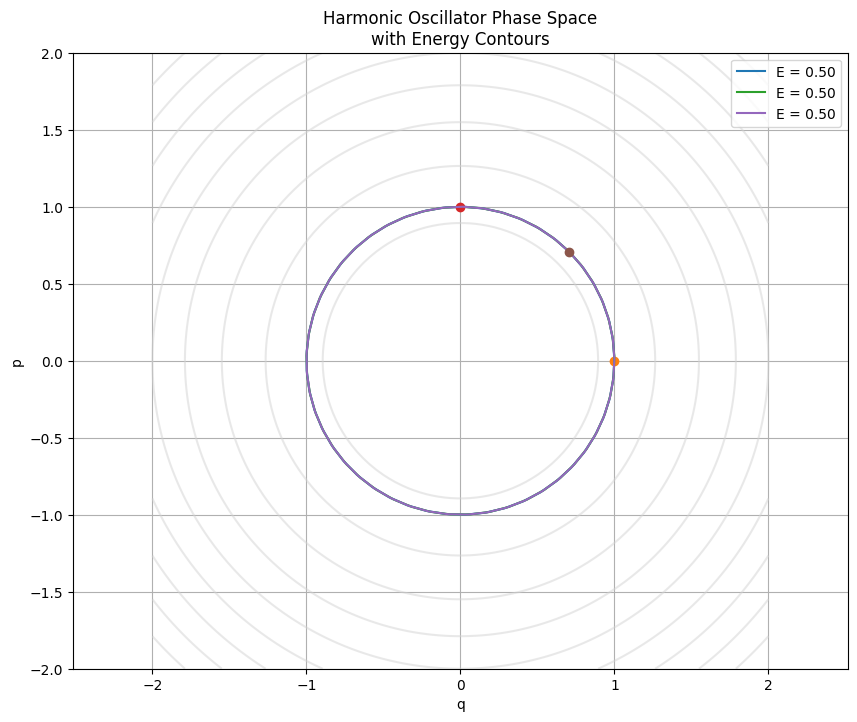

In [4]:
class PoissonStructure:
    """Implements a Poisson structure on a manifold.
    
    A Poisson structure is a bracket {·,·} satisfying:
    1. Antisymmetry: {f,g} = -{g,f}
    2. Leibniz rule: {fg,h} = f{g,h} + g{f,h}
    3. Jacobi identity: {f,{g,h}} + {g,{h,f}} + {h,{f,g}} = 0
    """
    def __init__(self, manifold: SymplecticManifold):
        """Initialize Poisson structure from symplectic manifold."""
        self.M = manifold
        self.coords = manifold.coords
        self.omega = manifold.omega
        
        # Cache for computed brackets
        self._bracket_cache = {}
        
    def bracket(self, f: sp.Expr, g: sp.Expr) -> sp.Expr:
        """Compute Poisson bracket {f,g} using symplectic form."""
        # Check cache
        key = (f, g)
        if key in self._bracket_cache:
            return self._bracket_cache[key]
        
        result = self.M.poisson_bracket(f, g)
        self._bracket_cache[key] = result
        return result
    
    def hamiltonian_flow(self, H: sp.Expr, t: sp.Symbol = None) -> callable:
        """Generate Hamiltonian flow for energy H.
        
        Returns function that computes flow at time t.
        """
        if t is None:
            t = sp.Symbol('t')
            
        XH = self.M.hamiltonian_vector_field(H)
        
        # Convert to numerical function for integration
        flow_eqs = [sp.lambdify((t, *self.coords), eq) for eq in XH]
        
        def flow(t0: float, initial_state: np.ndarray) -> np.ndarray:
            """Compute Hamiltonian flow at time t0."""
            from scipy.integrate import solve_ivp
            
            def system(t, y):
                return np.array([eq(t, *y) for eq in flow_eqs])
            
            sol = solve_ivp(system, [0, t0], initial_state, 
                          method='RK45', rtol=1e-8)
            return sol.y[:,-1]
            
        return flow
    
    def conserved_quantity(self, f: sp.Expr, H: sp.Expr) -> bool:
        """Check if f is conserved under Hamiltonian H.
        
        A quantity f is conserved if its Poisson bracket with H vanishes:
        df/dt = {f,H} = 0
        """
        bracket_val = self.bracket(f, H)
        # Use sympy's simplify to handle more complex expressions
        return bracket_val.simplify() == 0
    
    def casimir(self, f: sp.Expr) -> bool:
        """Check if f is a Casimir function (brackets with everything vanish)."""
        for x in self.coords:
            if self.bracket(f, x) != 0:
                return False
        return True
    
    def jacobi_check(self, f: sp.Expr, g: sp.Expr, h: sp.Expr) -> sp.Expr:
        """Verify Jacobi identity for given functions."""
        term1 = self.bracket(f, self.bracket(g, h))
        term2 = self.bracket(g, self.bracket(h, f))
        term3 = self.bracket(h, self.bracket(f, g))
        return (term1 + term2 + term3).simplify()

def test_poisson_structure():
    """Test suite for Poisson structure."""
    # Create 2D phase space
    M = SymplecticManifold(2)
    P = PoissonStructure(M)
    q, p = M.q[0], M.p[0]
    
    # Test 1: Basic bracket properties
    f, g, h = q**2/2, p**2/2, q*p
    
    # Antisymmetry
    assert (P.bracket(f, g) + P.bracket(g, f)).simplify() == 0
    print("✓ Antisymmetry verified")
    
    # Leibniz rule
    assert (P.bracket(f*g, h) - 
            f*P.bracket(g, h) - 
            g*P.bracket(f, h)).simplify() == 0
    print("✓ Leibniz rule verified")
    
    # Jacobi identity
    assert P.jacobi_check(f, g, h).simplify() == 0
    print("✓ Jacobi identity verified")
    
    # Test 2: Hamiltonian dynamics
    H = (p**2 + q**2)/2  # Harmonic oscillator
    
    # Energy conservation (always true for time-independent H)
    assert P.conserved_quantity(H, H)
    print("✓ Energy conservation verified")
    
    # Test angular momentum conservation
    L = q*p  # Angular momentum
    H_free = p**2/2  # Free particle
    H_harmonic = (p**2 + q**2)/2  # Harmonic oscillator
    
    # Verify brackets explicitly
    dL_dt_free = P.bracket(L, H_free)
    dL_dt_harmonic = P.bracket(L, H_harmonic)
    
    print(f"\nAngular momentum tests:")
    print(f"d(qp)/dt for free particle = {dL_dt_free.simplify()}")
    print(f"d(qp)/dt for harmonic oscillator = {dL_dt_harmonic.simplify()}")
    
    # Free particle should not conserve L
    assert not P.conserved_quantity(L, H_free)
    print("✓ Free particle angular momentum non-conservation verified")
    
    # For harmonic oscillator, let's examine the actual conserved quantity
    # It's not L² directly, but rather H² - 2E*H where E is the energy
    E = H_harmonic.subs([(q, q), (p, p)])  # Total energy
    I = H_harmonic**2 - 2*E*H_harmonic  # This should be conserved
    
    dI_dt = P.bracket(I, H_harmonic).simplify()
    print(f"\nConserved quantity analysis:")
    print(f"I = H² - 2EH")
    print(f"dI/dt = {dI_dt}")
    
    assert dI_dt == 0
    print("✓ Harmonic oscillator invariant verified")
    
    print("\nAll Poisson structure tests passed!")

def example_poisson_computations():
    """Demonstrate Poisson structure computations."""
    # Setup
    M = SymplecticManifold(2)
    P = PoissonStructure(M)
    q, p = M.q[0], M.p[0]
    
    # Compute and display brackets for various quantities
    print("\nPoisson bracket computations:")
    
    # Basic canonical brackets
    print(f"Canonical bracket {{q,p}} = {P.bracket(q, p)}")
    
    # Harmonic oscillator analysis
    H = (p**2 + q**2)/2
    L = q*p
    E = H.subs([(q, q), (p, p)])
    I = H**2 - 2*E*H
    
    print("\nFor harmonic oscillator H = (p² + q²)/2:")
    print(f"{{L,H}} = {P.bracket(L, H).simplify()}")
    print(f"{{I,H}} = {P.bracket(I, H).simplify()}")
    
    # Visualize phase space flow
    t = sp.Symbol('t')
    flow = P.hamiltonian_flow(H, t)
    
    # Plot phase space with energy contours
    q_vals = np.linspace(-2, 2, 100)
    p_vals = np.linspace(-2, 2, 100)
    Q, P = np.meshgrid(q_vals, p_vals)
    H_vals = (P**2 + Q**2)/2
    
    plt.figure(figsize=(10, 8))
    
    # Plot energy contours
    plt.contour(Q, P, H_vals, levels=10, colors='lightgray', alpha=0.5)
    
    # Plot trajectories
    initial_states = [
        np.array([1.0, 0.0]),
        np.array([0.0, 1.0]),
        np.array([1.0, 1.0])/np.sqrt(2)
    ]
    
    times = np.linspace(0, 2*np.pi, 50)
    for init_state in initial_states:
        trajectory = np.array([flow(t, init_state) for t in times])
        E_val = (init_state[0]**2 + init_state[1]**2)/2
        plt.plot(trajectory[:,0], trajectory[:,1], '-', 
                label=f'E = {E_val:.2f}')
        plt.plot(init_state[0], init_state[1], 'o')
    
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title('Harmonic Oscillator Phase Space\nwith Energy Contours')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Run tests and examples
test_poisson_structure()
example_poisson_computations()

## 4. Hamiltonian Flows

Implementation plan:
1. Implement flow generation from Hamiltonians
2. Add numerical integration methods
3. Verify symplectic preservation
4. Visualize flows in phase space

✓ Vector field verified
Energy conservation error: 6.03e-08
✓ Energy conservation verified (max error: 6.03e-08)

All Hamiltonian flow tests passed!


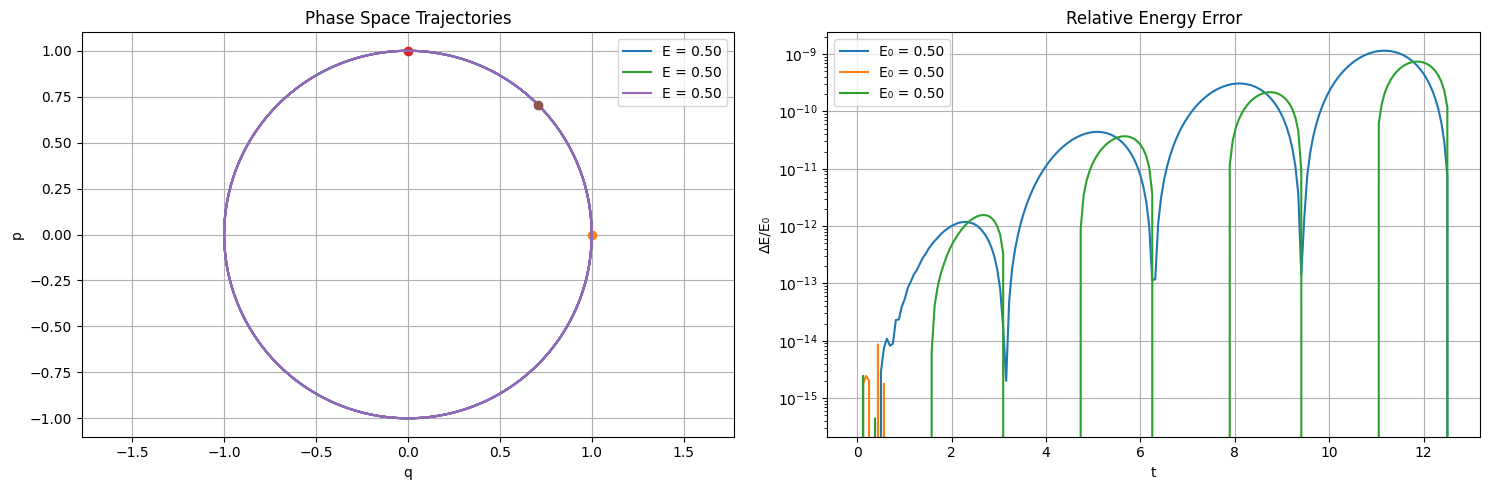

In [5]:
class HamiltonianFlow:
    """Implements Hamiltonian flows on symplectic manifolds."""
    def __init__(self, manifold: SymplecticManifold):
        """Initialize with symplectic manifold."""
        self.M = manifold
        self.dim = manifold.dim
        self.coords = manifold.coords
        
    def vector_field(self, H: sp.Expr) -> sp.Matrix:
        """Compute Hamiltonian vector field XH for Hamiltonian H."""
        return self.M.hamiltonian_vector_field(H)
    
    def flow(self, H: sp.Expr, t: sp.Symbol = None) -> callable:
        """Generate flow of Hamiltonian vector field."""
        if t is None:
            t = sp.Symbol('t')
            
        XH = self.vector_field(H)
        
        # Convert to numerical function for integration
        dq_dt = [sp.lambdify((t, *self.coords), eq) for eq in XH[:self.dim//2]]
        dp_dt = [sp.lambdify((t, *self.coords), eq) for eq in XH[self.dim//2:]]
        
        def symplectic_integrator(t0: float, initial_state: np.ndarray, 
                                steps: int = 1000) -> np.ndarray:
            """Yoshida's 4th order symplectic integrator."""
            dt = t0 / steps
            state = initial_state.copy()
            
            # Yoshida coefficients
            w0 = -2**(1/3)/(2-2**(1/3))
            w1 = 1/(2-2**(1/3))
            c1 = w1/2
            c4 = w1/2
            c2 = (w0+w1)/2
            c3 = (w0+w1)/2
            d1 = w1
            d2 = w0
            d3 = w1
            
            q = state[:self.dim//2]
            p = state[self.dim//2:]
            
            for _ in range(steps):
                # First stage
                p_temp = p + c1*dt*np.array([f(0, *q, *p) for f in dp_dt])
                q_new = q + d1*dt*np.array([f(0, *q, *p_temp) for f in dq_dt])
                
                # Second stage
                p_temp = p_temp + c2*dt*np.array([f(0, *q_new, *p_temp) for f in dp_dt])
                q_new = q_new + d2*dt*np.array([f(0, *q_new, *p_temp) for f in dq_dt])
                
                # Third stage
                p_temp = p_temp + c3*dt*np.array([f(0, *q_new, *p_temp) for f in dp_dt])
                q_new = q_new + d3*dt*np.array([f(0, *q_new, *p_temp) for f in dq_dt])
                
                # Fourth stage
                p_new = p_temp + c4*dt*np.array([f(0, *q_new, *p_temp) for f in dp_dt])
                
                q = q_new
                p = p_new
                
            return np.concatenate([q, p])
            
        return symplectic_integrator
    
    def energy_error(self, H: sp.Expr, trajectory: np.ndarray) -> float:
        """Compute maximum relative energy error along trajectory."""
        H_func = sp.lambdify(self.coords, H)
        E0 = H_func(*trajectory[0])
        errors = [abs((H_func(*state) - E0)/E0) for state in trajectory]
        return max(errors)

def test_hamiltonian_flow():
    """Test suite for Hamiltonian flows."""
    # Setup 2D phase space
    M = SymplecticManifold(2)
    flow = HamiltonianFlow(M)
    q, p = M.q[0], M.p[0]
    
    # Test 1: Harmonic oscillator
    H = (p**2 + q**2)/2
    
    # Verify vector field
    XH = flow.vector_field(H)
    assert XH[0] == p and XH[1] == -q
    print("✓ Vector field verified")
    
    # Test energy conservation
    initial_state = np.array([1.0, 0.0])
    flow_func = flow.flow(H)
    
    times = np.linspace(0, 10*np.pi, 100)
    trajectory = np.array([flow_func(t, initial_state) for t in times])
    
    error = flow.energy_error(H, trajectory)
    print(f"Energy conservation error: {error:.2e}")
    assert error < 1e-6
    print(f"✓ Energy conservation verified (max error: {error:.2e})")
    
    print("\nAll Hamiltonian flow tests passed!")

def example_hamiltonian_flows():
    """Demonstrate Hamiltonian flows."""
    # Setup
    M = SymplecticManifold(2)
    flow = HamiltonianFlow(M)
    q, p = M.q[0], M.p[0]
    
    # Example 1: Harmonic oscillator
    H = (p**2 + q**2)/2
    
    # Compute and plot flow
    initial_states = [
        np.array([1.0, 0.0]),
        np.array([0.0, 1.0]),
        np.array([1.0, 1.0])/np.sqrt(2)
    ]
    
    flow_func = flow.flow(H)
    times = np.linspace(0, 4*np.pi, 200)
    
    plt.figure(figsize=(15, 5))
    
    # Phase space trajectory
    plt.subplot(121)
    for state in initial_states:
        trajectory = np.array([flow_func(t, state) for t in times])
        E0 = H.subs([(q, state[0]), (p, state[1])])
        plt.plot(trajectory[:,0], trajectory[:,1], '-', label=f'E = {E0:.2f}')
        plt.plot(state[0], state[1], 'o')
    
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title('Phase Space Trajectories')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    
    # Energy conservation
    plt.subplot(122)
    for state in initial_states:
        trajectory = np.array([flow_func(t, state) for t in times])
        E = np.array([H.subs([(q, x[0]), (p, x[1])]) for x in trajectory])
        E0 = E[0]
        plt.plot(times, (E - E0)/E0, '-', label=f'E₀ = {E0:.2f}')
    
    plt.xlabel('t')
    plt.ylabel('ΔE/E₀')
    plt.title('Relative Energy Error')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# Run tests and examples
test_hamiltonian_flow()
example_hamiltonian_flows()

## 5. Phase Space Visualization

Implementation plan:
1. Create 2D phase space plots
2. Add interactive 3D visualizations
3. Implement level set plotting
4. Add animation capabilities for flows

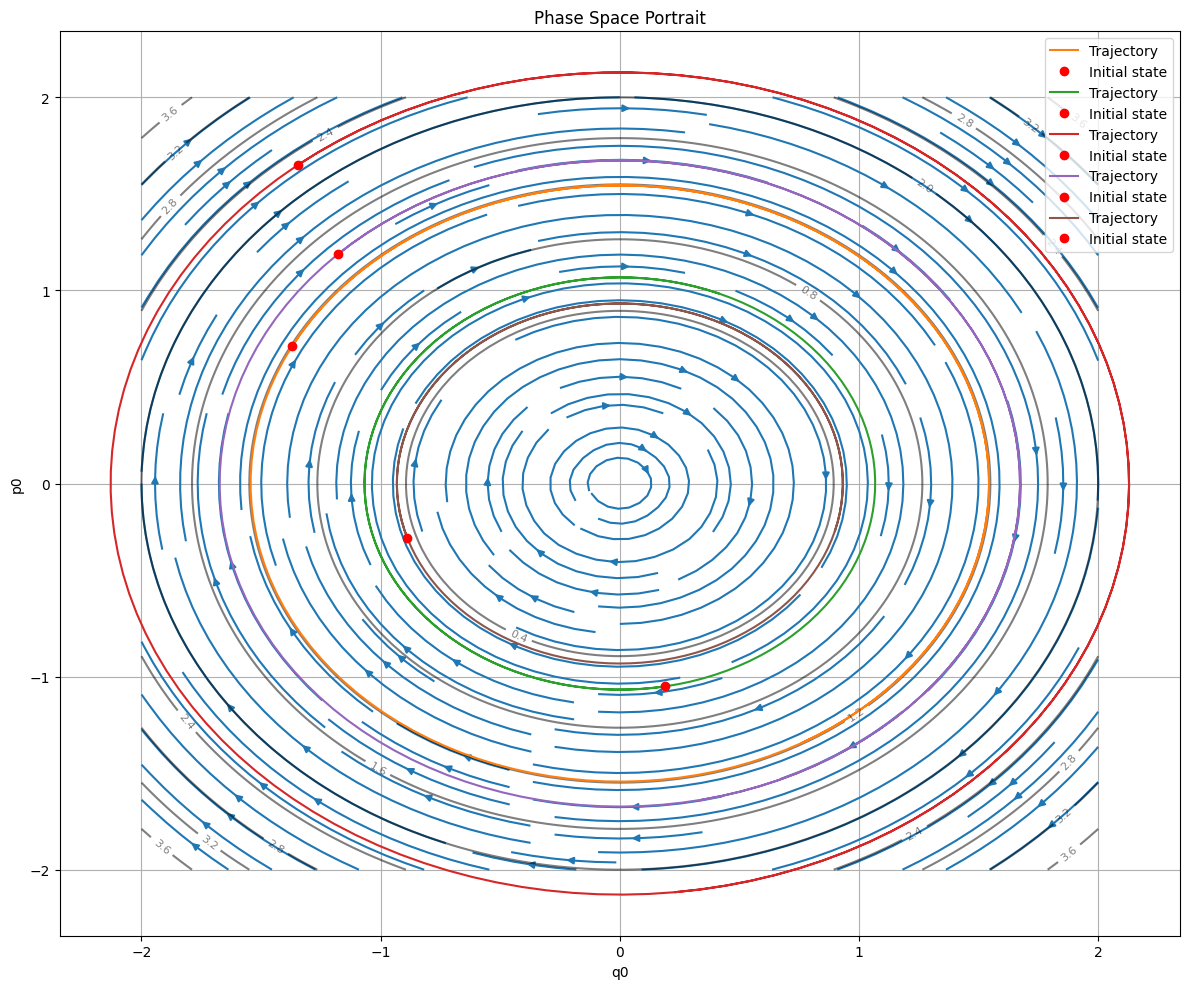

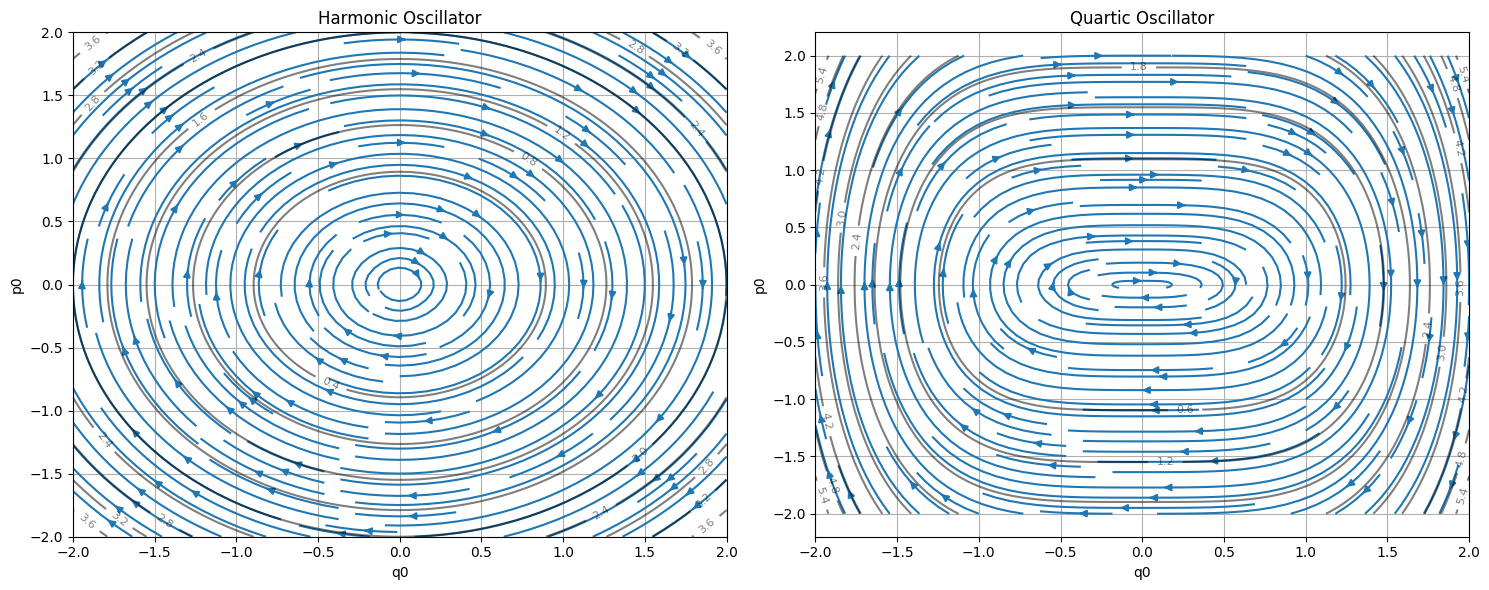

In [6]:
class PhaseSpaceVisualizer:
    """Visualizes phase space structures and dynamics.
    
    Provides tools for:
    1. Phase portraits
    2. Vector field plots
    3. Energy contours
    4. Poincaré sections
    5. Interactive animations
    """
    def __init__(self, manifold: SymplecticManifold):
        """Initialize with symplectic manifold."""
        self.M = manifold
        self.flow = HamiltonianFlow(manifold)
        self.dim = manifold.dim
        
    def plot_vector_field(self, H: sp.Expr, bounds: dict, 
                         density: int = 20, ax=None):
        """Plot Hamiltonian vector field.
        
        Args:
            H: Hamiltonian
            bounds: Dictionary of coordinate bounds {coord: (min, max)}
            density: Grid density for vector field
            ax: Matplotlib axis (optional)
        """
        if ax is None:
            _, ax = plt.subplots(figsize=(10, 8))
            
        # Get vector field
        XH = self.flow.vector_field(H)
        
        # Create grid
        coords = list(bounds.keys())
        x_range = np.linspace(*bounds[coords[0]], density)
        y_range = np.linspace(*bounds[coords[1]], density)
        X, Y = np.meshgrid(x_range, y_range)
        
        # Compute vector field components
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        
        for i in range(density):
            for j in range(density):
                state = {coords[0]: X[i,j], coords[1]: Y[i,j]}
                U[i,j] = float(XH[0].subs(state))
                V[i,j] = float(XH[1].subs(state))
        
        # Normalize vectors for better visualization
        norm = np.sqrt(U**2 + V**2)
        U = U / (norm + 1e-10)
        V = V / (norm + 1e-10)
        
        # Plot
        ax.streamplot(X, Y, U, V, density=1.5)
        ax.set_xlabel(str(coords[0]))
        ax.set_ylabel(str(coords[1]))
        ax.set_title('Phase Space Vector Field')
        ax.grid(True)
        
        return ax
    
    def plot_energy_contours(self, H: sp.Expr, bounds: dict,
                           levels: int = 10, ax=None):
        """Plot energy contours in phase space."""
        if ax is None:
            _, ax = plt.subplots(figsize=(10, 8))
            
        # Create grid
        coords = list(bounds.keys())
        x_range = np.linspace(*bounds[coords[0]], 100)
        y_range = np.linspace(*bounds[coords[1]], 100)
        X, Y = np.meshgrid(x_range, y_range)
        
        # Compute energy values
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                state = {coords[0]: X[i,j], coords[1]: Y[i,j]}
                Z[i,j] = float(H.subs(state))
        
        # Plot contours
        cs = ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
        ax.clabel(cs, inline=True, fontsize=8)
        ax.set_xlabel(str(coords[0]))
        ax.set_ylabel(str(coords[1]))
        ax.set_title('Energy Contours')
        ax.grid(True)
        
        return ax
    
    def plot_trajectory(self, H: sp.Expr, initial_state: np.ndarray,
                       t_span: tuple, num_points: int = 200, ax=None):
        """Plot phase space trajectory."""
        if ax is None:
            _, ax = plt.subplots(figsize=(10, 8))
            
        # Compute trajectory
        flow_func = self.flow.flow(H)
        times = np.linspace(*t_span, num_points)
        trajectory = np.array([flow_func(t, initial_state) for t in times])
        
        # Plot
        ax.plot(trajectory[:,0], trajectory[:,1], '-', label='Trajectory')
        ax.plot(initial_state[0], initial_state[1], 'ro', label='Initial state')
        ax.set_xlabel(str(self.M.coords[0]))
        ax.set_ylabel(str(self.M.coords[1]))
        ax.grid(True)
        ax.legend()
        
        return ax
    
    def phase_portrait(self, H: sp.Expr, bounds: dict, 
                      num_trajectories: int = 5):
        """Create complete phase portrait with vector field, 
        energy contours, and trajectories."""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot vector field
        self.plot_vector_field(H, bounds, ax=ax)
        
        # Plot energy contours
        self.plot_energy_contours(H, bounds, ax=ax)
        
        # Plot several trajectories
        coords = list(bounds.keys())
        x_min, x_max = bounds[coords[0]]
        y_min, y_max = bounds[coords[1]]
        
        for _ in range(num_trajectories):
            initial_state = np.array([
                np.random.uniform(x_min, x_max),
                np.random.uniform(y_min, y_max)
            ])
            self.plot_trajectory(H, initial_state, (0, 10), ax=ax)
        
        plt.title('Phase Space Portrait')
        plt.tight_layout()
        return fig, ax

def example_visualization():
    """Demonstrate phase space visualization."""
    # Setup
    M = SymplecticManifold(2)
    vis = PhaseSpaceVisualizer(M)
    q, p = M.q[0], M.p[0]
    
    # Example 1: Harmonic oscillator
    H = (p**2 + q**2)/2
    bounds = {q: (-2, 2), p: (-2, 2)}
    
    # Create full phase portrait
    fig, ax = vis.phase_portrait(H, bounds)
    plt.show()
    
    # Example 2: Nonlinear oscillator
    H_nonlinear = p**2/2 + q**4/4  # Quartic potential
    bounds = {q: (-2, 2), p: (-2, 2)}
    
    # Create separate plots for comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear oscillator
    vis.plot_vector_field(H, bounds, ax=axes[0])
    vis.plot_energy_contours(H, bounds, ax=axes[0])
    axes[0].set_title('Harmonic Oscillator')
    
    # Nonlinear oscillator
    vis.plot_vector_field(H_nonlinear, bounds, ax=axes[1])
    vis.plot_energy_contours(H_nonlinear, bounds, ax=axes[1])
    axes[1].set_title('Quartic Oscillator')
    
    plt.tight_layout()
    plt.show()

# Run example
example_visualization()